# Scenario F - Dataset Real (Tablets NIR)

In this scenario the the probabilistic model is tested on real-world datasets. The model parameters differ per dataset, and are set by the user. The probabilistic model is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + a_0 + a_1 \cdot x + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf
from data import Data

## Local configuration

In [3]:
# output for results and images
out_path      = './output_data_real_tablets'
file_basename = out_path + '/scenario_data_real_tablets'
        
conf = {}
    
# scenario name
conf['scenario'] = 'dataset real'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors) (normal/lognormal/eta_rv)
conf['prior_model'] = 'normal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'dataset real',
 'init_mode': 'adapt_diag',
 'prior_model': 'normal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Import data and plot

In [6]:
# dataset filelocation
dataset_filename = '../../../data/tablets/NIR_tablets.csv'

# dataset object init
data_obj = Data(dataset_filename, shuffle='yes')
data_obj.data.head(5)

,7398.337,7406.051,7413.766,7421.481,7429.195,7436.91,7444.624,7452.339,7460.053,7467.768,...,10461.02,10468.73,10476.45,10484.16,10491.88,10499.59,10507.3,content (% w/w),label,scale
136,0.516769,0.474448,0.433386,0.393728,0.356985,0.323353,0.292610,0.264723,0.239025,0.214776,...,-0.471675,-0.472897,-0.472426,-0.473669,-0.477151,-0.478926,-0.477607,8.624898,2,2
183,1.732031,1.661568,1.592955,1.528255,1.466749,1.410594,1.361027,1.315644,1.273496,1.234665,...,0.169074,0.168341,0.171370,0.169594,0.162108,0.159557,0.164059,7.728459,3,1
278,2.279227,2.189396,2.111371,2.047314,1.986221,1.919948,1.859506,1.810529,1.767993,1.727444,...,0.529430,0.529923,0.532409,0.528858,0.521243,0.518674,0.521829,8.153014,4,1
171,1.687539,1.616431,1.551584,1.490466,1.431096,1.376016,1.326649,1.282420,1.242018,1.203878,...,0.146605,0.145532,0.148532,0.147576,0.140760,0.137827,0.141905,7.676240,3,1
87,0.722221,0.673404,0.625943,0.580010,0.537407,0.498390,0.462804,0.430392,0.400116,0.371492,...,-0.438397,-0.439183,-0.437967,-0.439331,-0.443822,-0.446095,-0.444240,7.442597,2,0


In [7]:
# drop non-data columns
df = data_obj.data.drop(columns=['label','scale','content (% w/w)'])

In [8]:
print("total number of spectra  : {0}".format(len(df)))
print("total number of x-values : {0}".format(len(np.array(df.columns.to_list(), dtype='float32'))))
print("total number of classes  : {0}".format(data_obj.classes))
print("\nclass distribution:")
print(data_obj.data[data_obj.label_column].value_counts())

total number of spectra  : 310
total number of x-values : 404
total number of classes  : 4

class distribution:
4    80
3    80
2    80
1    70
Name: label, dtype: int64


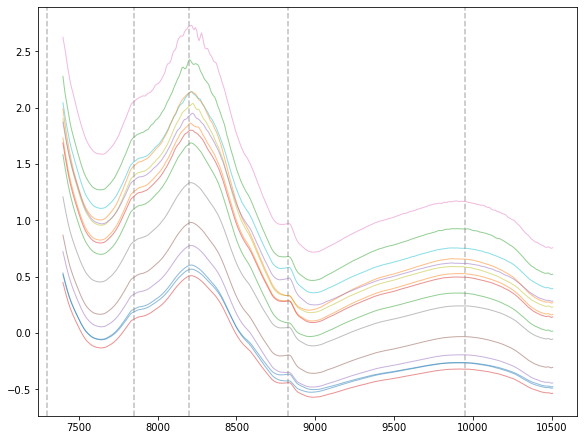

In [9]:
# number of samples to run inference on
nsamples = 15

# set peak information for spectrum
peaks = [7300.0, 7850.0, 8200.0, 8830.0, 9950.0]

# baseline profile
base_shape = 'offset'

# plot dataset (nsamples spectra, classes mixed)
fig.plot_datasets_real(df, peaks, nsamples, savefig='yes', fname=file_basename)

# Initialize models and run inference

In [10]:
ldata  = []
lpeaks = []

# add dataframes and peakinfo to list (for multiple classes or data per class)
ldata.append(df)
lpeaks.append(peaks)

In [11]:
# convert pandas data to numpy arrays
x_val = np.array(df.columns, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values[:nsamples] for i in range(len(ldata))]

In [12]:
# initialize models and run inference
models = []
traces = []

for i in range(len(ldata)):
    if conf['peak_info'] == 'yes':
        plist = np.array(lpeaks[0], dtype='float32').flatten()
        plist.sort()
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                              mu_peaks=plist, pmodel=conf['prior_model'], baseline=base_shape)
    else:
        model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=len(peaks),
                                              pmodel=conf['prior_model'], baseline=base_shape)
                
    models.append(model_g)

    with model_g:
        if conf['model_mode'] == 'train':
            print("running inference on dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
            traces.append(trace_g)
            # save inference results
            pm.backends.text.dump(out_path + '/traces_%02d' % (i+1), trace_g)
        else:
            # load traces from disk
            print("loading dataset #{0}/{1}".format(i+1,len(ldata)))
            trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (i+1))
            traces.append(trace_g)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


running inference on dataset #1/1


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, a0, sigma, mu, amp]
Sampling 2 chains, 2,606 divergences: 100%|██████████| 5000/5000 [05:15<00:00, 15.84draws/s] 
There were 1292 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1313 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.676375550909749, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


# Model visualization

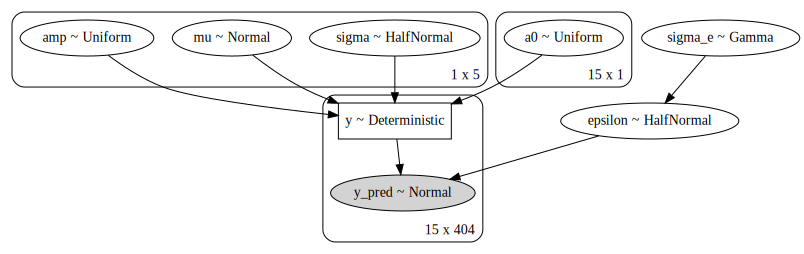

In [13]:
# display first model
pm.model_to_graphviz(models[0])

In [14]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [15]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 329.15it/s]


In [16]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])
#az.summary(traces[1], varnames)

In [17]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, varnames)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
df

,r_hat,mcse,ess,bfmi,r2,waic,epsilon
1,1.030968,0.631677,102.322581,0.958772,0.791976,1094.602645,0.264512


In [18]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

In [19]:
cnf.close(out_path)

# Plot posterior (single dataset)

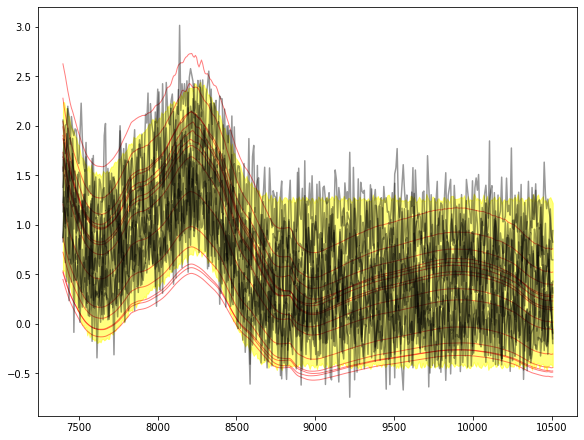

In [23]:
# dataset to plot
n_dataset = 0

# trace number in matrix
n_trace = 0

#fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 10, file_basename, hpd_color='yellow',
#                         peak_pos=peaks)
fig.plot_posterior_single(x_val, ldata[n_dataset], ppc[n_trace], 10, file_basename, hpd_color='yellow')

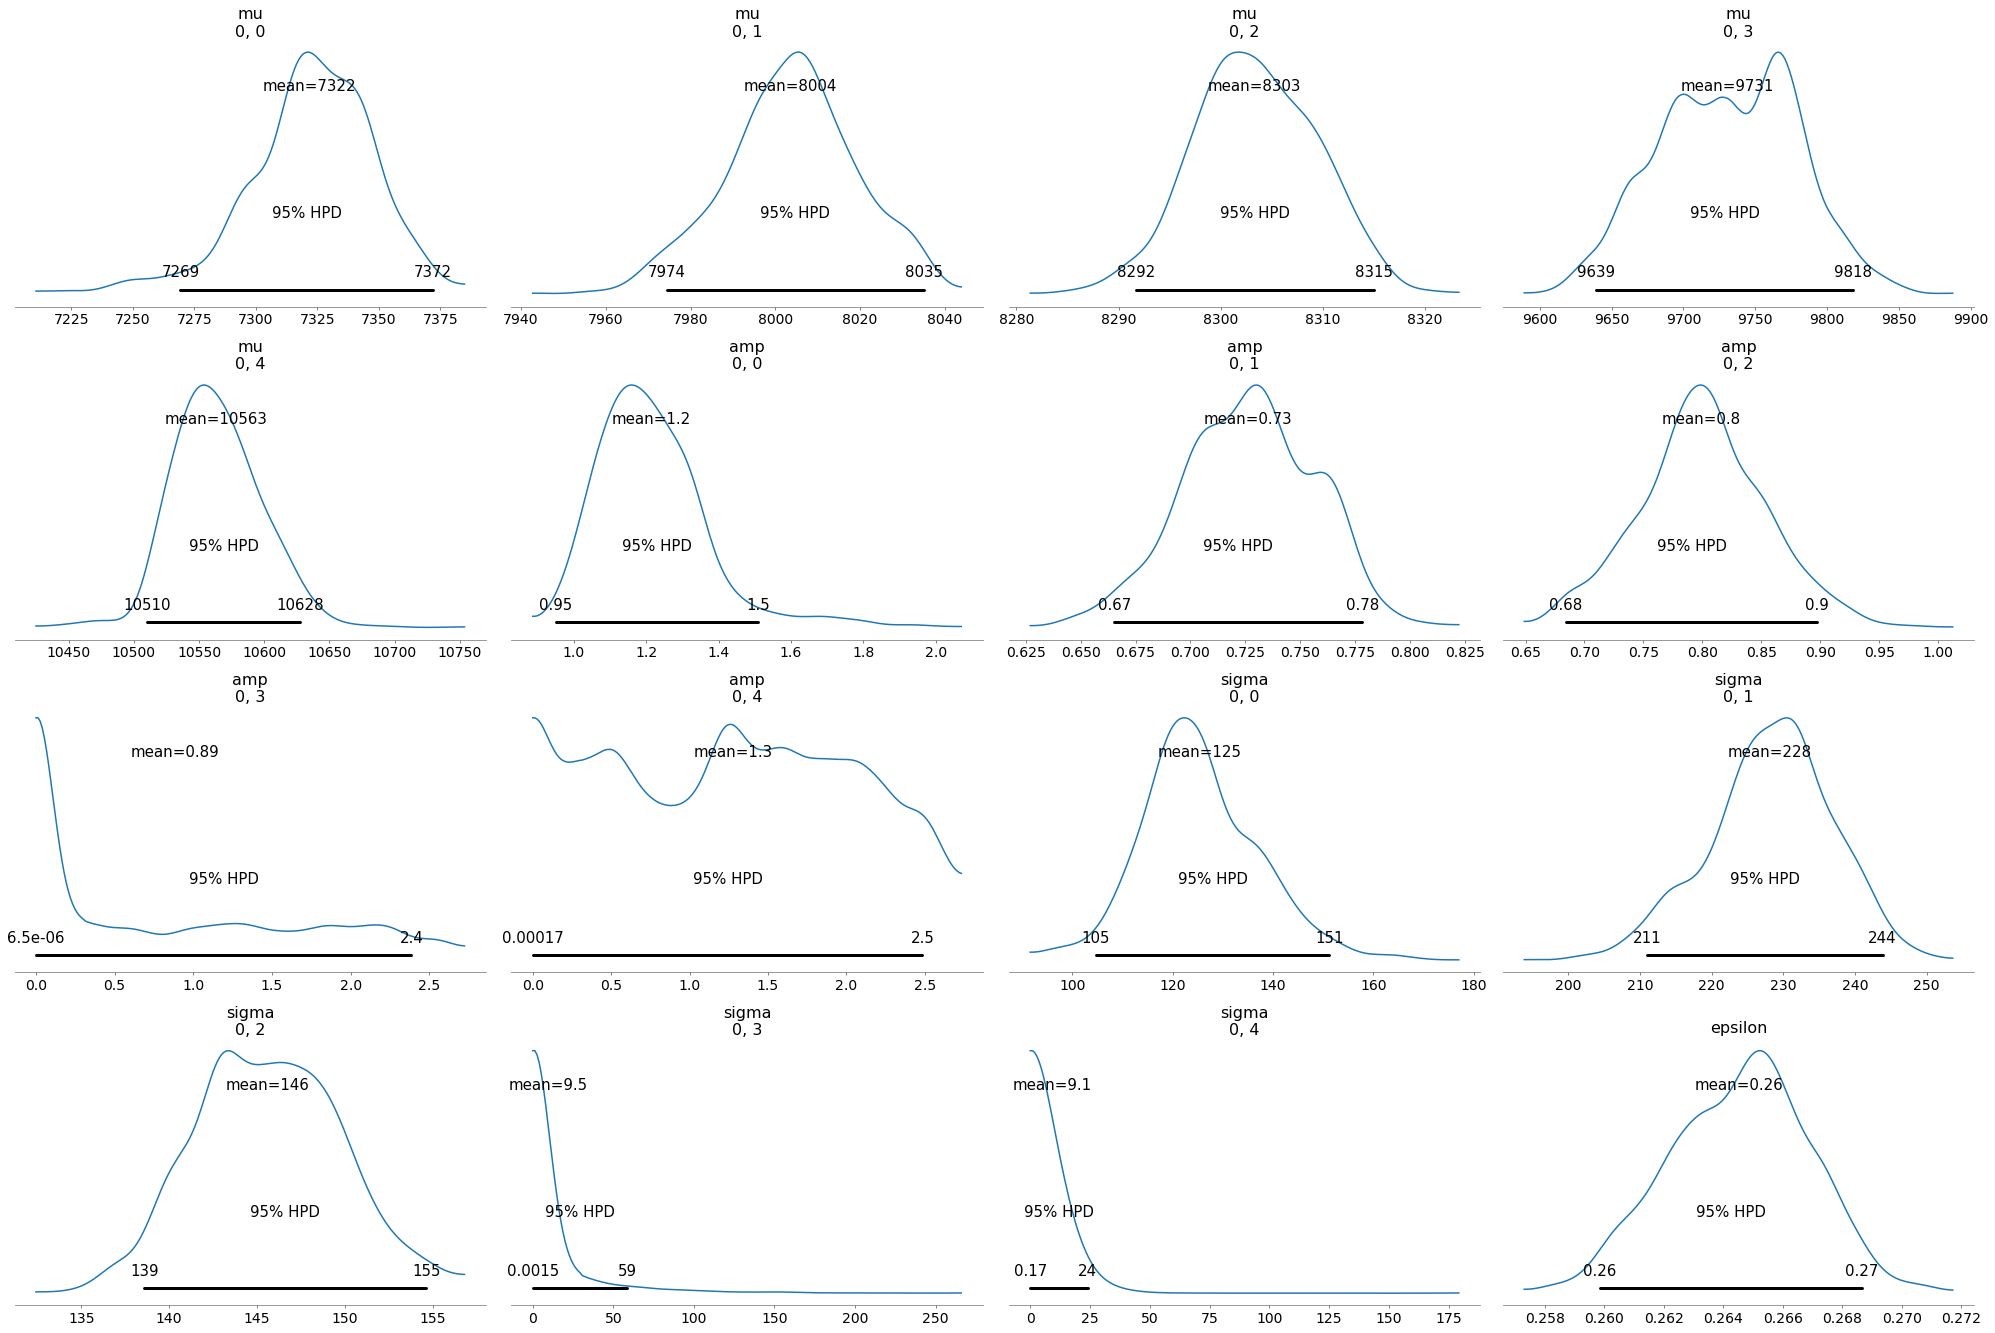

In [21]:
az.plot_posterior(traces[n_trace], ['mu', 'amp', 'sigma', 'epsilon'], credible_interval=0.95);

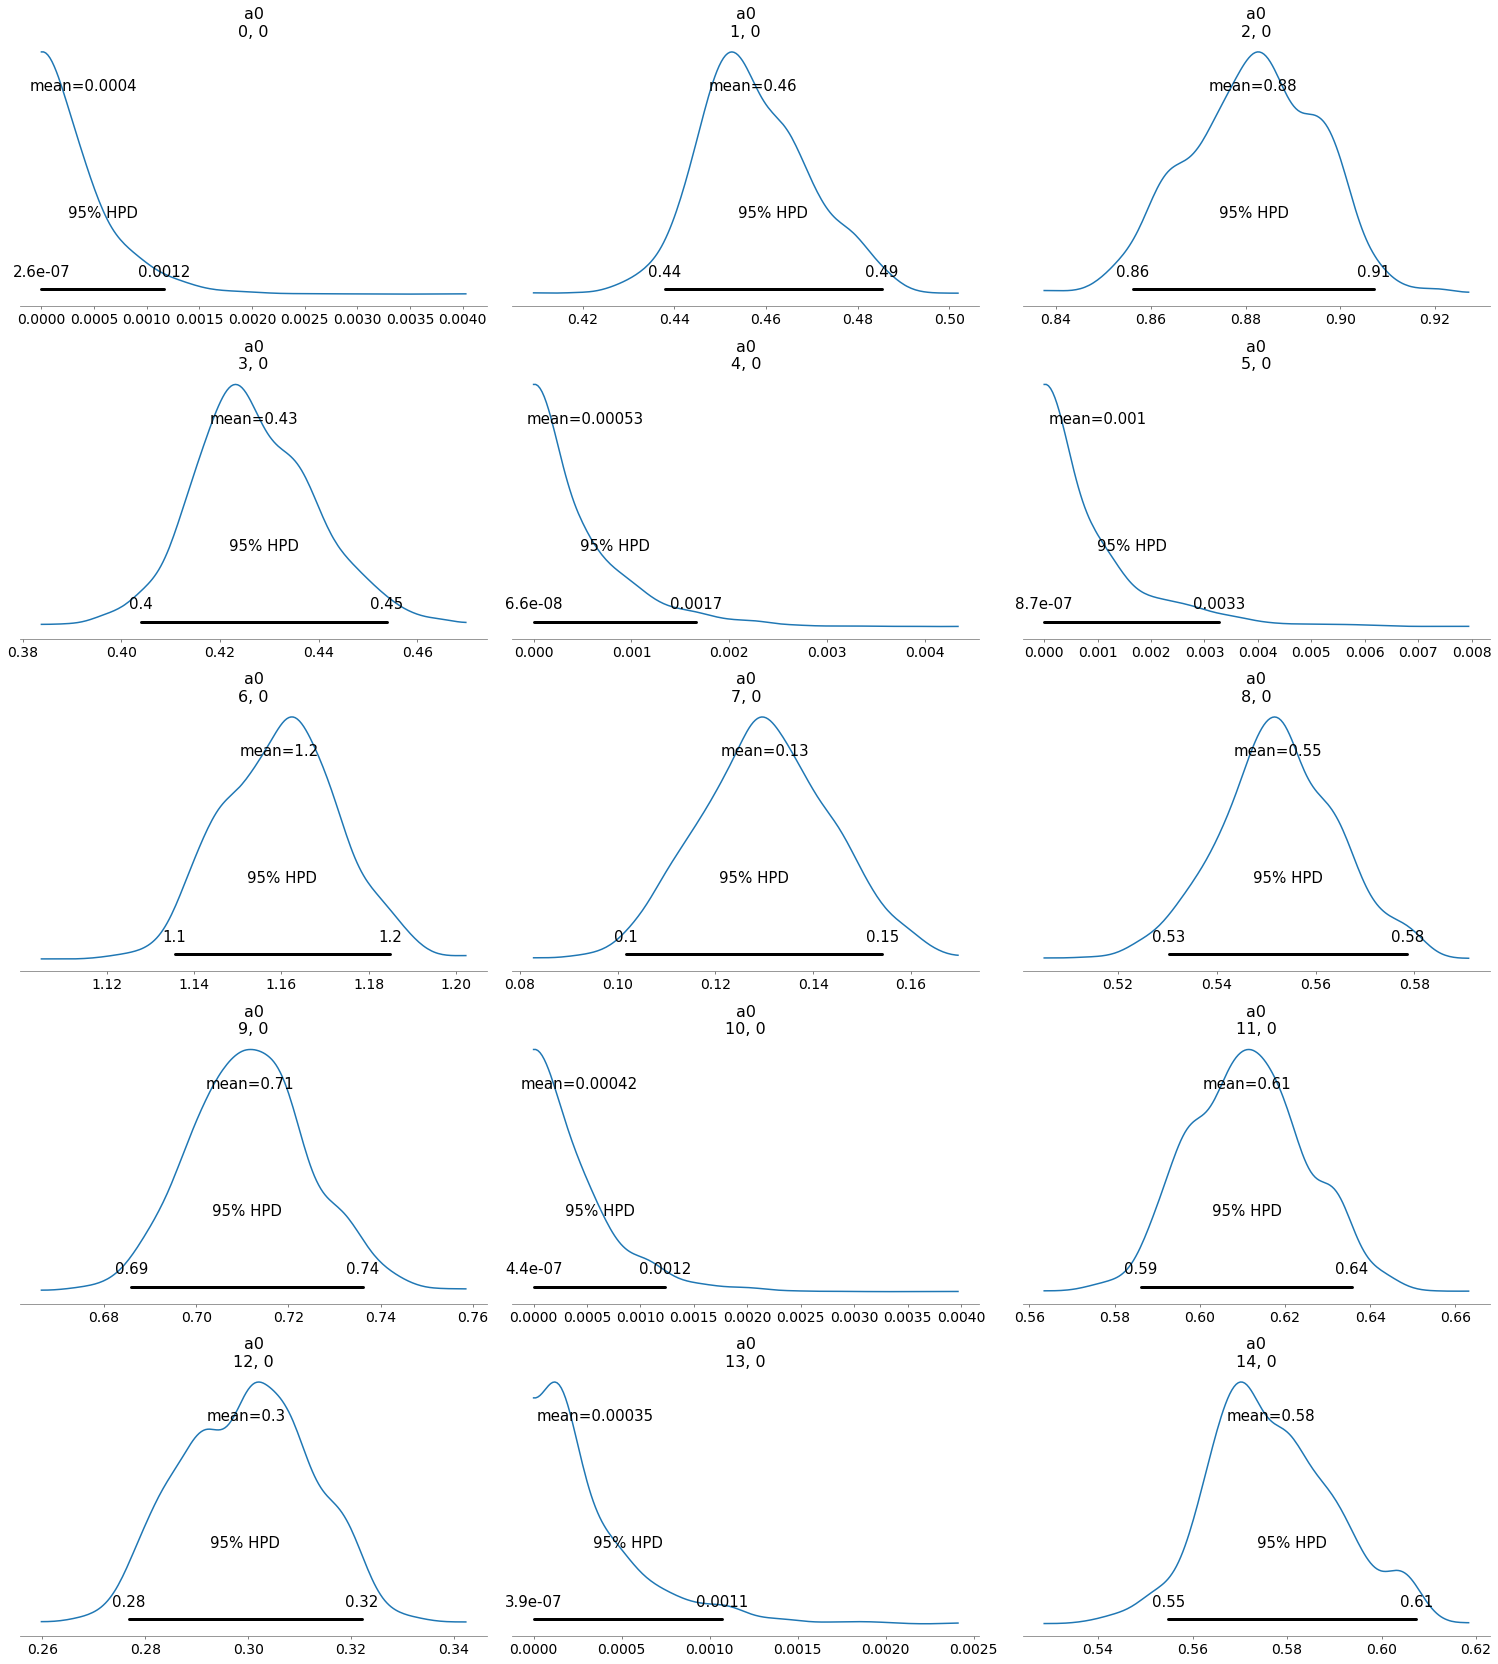

In [22]:
az.plot_posterior(traces[n_trace], ['a0'], credible_interval=0.95);